## Multi Arm Bandit Approaches to A/B Testing

As someone who has spent a good deal of time designing, running and analyzing A/B tests, I have always been interested, but never had the chance to implement, Multi Arm Bandit approaches. Just picturing never having to calculate sample size, the running time of an experiment or significance testing seemed like a dream. However, due to technical limitations of the product and lack of experience with Bayesian approaches (I was mostly focused on Frequentist approaches in graduate school) running experiments in a probabilistic way was just a pipe dream.

Finally, I wanted to dive into MAB headfirst without waiting for an applied opportunity at work.
Since the best way to learn an algorism is to code it from scratch, I decided to write my own, simple implementation of the Multi Arm Bandit algorism.
There are many different types of Multi Arm Bandit approaches, so before I chose one, I want to make sure I understand each approach.

### Naive Approach:

A naive approach to this methodology is to select an ad at random. This is similar to a traditional A/B test since those usually assign users to random groups that display an associated ad.

### Epsilon Greedy:

This is a more adaptive method that tries to serve the bandit/ad that is outperforming the rest, while at the same time balancing the need to "explore" and test the effectiveness of other ads.
It works by preemptively deciding on some level of epsilon (percent of explorations) and choosing an ad at random a certain percent of time in order to keep exploring your ads to make sure you are not locked into an ad too early.



### Here is an Example of Epsilon Greedy Algorism:

In [132]:
eps = .10

list_of_bandits= [.33,.28,.65]

def random_choice (some_list):
    return np.random.randint(0, len(some_list))

def eps_greedy(list_of_bandits):
    while True:
        if np.random.rand() > eps:
            return list_of_bandits[random_choice(list_of_bandits)]
        else: 
            # show the best choice clicks/impressions
            winning_ad = np.argmax(list_of_bandits)
            return list_of_bandits[winning_ad]

### UCB1 Algorism.

This is a modified form of epsilon greedy algorism that recalculates epsilon after each iteration. The formula for this update is  argmax  ( square_root_of (estimated_mean + (2lnN/nj)). We chose the bandit with the highest upper bound confidence interval and play that arm. We then update the estimated mean of the chosen bandit. 

The nice thing about this algorism is that it balances exploiting and exploring. For example, if the estimated mean is large then we are more likely to exploit. Since the second part of the formula includes both the number of total pulls as well as the number of pulls for a specific bandit, it dictates more exploration, by increasing the upper confidence bound, if the bandit specific n is much smaller then total N. On the other hand, when n is large (N/n is smaller), we will just be using the estimated means, since the other part of the formula will approach zero. 


#### Here is a basic implementation of this algorism:

Bandit 0 with probability 0.35 was pulled 92 times with 27 successes
Bandit 1 with probability 0.25 was pulled 60 times with 12 successes
Bandit 2 with probability 0.6 was pulled 851 times with 470 successes


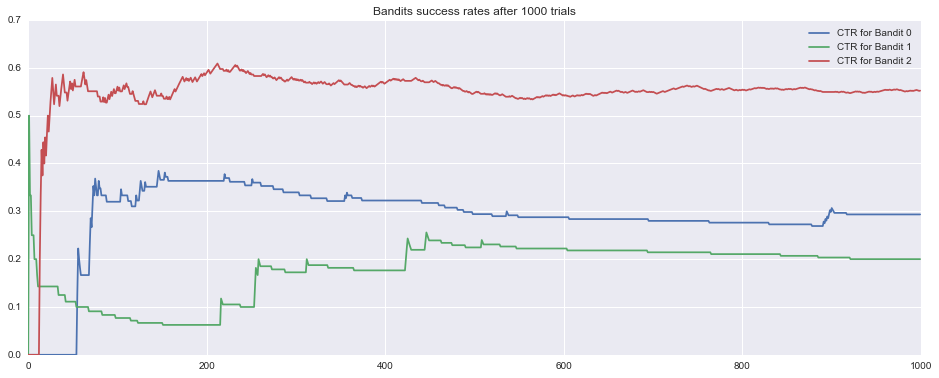

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt

counts = [1,1,1]
wins = [0,0,0]
probs = [0.35, 0.25, 0.60]
trials = 1000
mean = [0.0,0.0,0.0]
cumil_means = [[],[],[]]



def update (indx, result):
    counts[indx] +=1 
    wins[indx]+= result
    mean[indx]= wins[indx]/float (counts[indx])
    #print 'updating wins:{} counts :{} mean{}'.format(wins,counts, mean)

def roll (prob):
    if prob > np.random.random():
        return 1
    else:
        return 0

    
def plot(means,bandit):
    plot_x = xrange(trials)
    plt.plot(means, label = "CTR for Bandit {}".format(bandit))
    plt.title("Bandits success rates after %s trials" % trials)
    plt.legend()
    #plt.show()
    
    
    
def ucb1(trials):
    outcomes = np.empty(trials)
    for each in xrange (0, trials):
        total_counts = sum(counts)
        ucb_values = [0.0,0.0,0.0]
        for arm in range (0, len (probs)):
            # calculate upper interval
            bonus = np.sqrt(2 * np.log(total_counts) / (counts[arm] +1))
            ucb_values[arm] = mean[arm]+bonus
        # grab largest interval
        largest = np.argmax(ucb_values)
        update(largest, roll(probs[largest]))
        # append means after update
        for indx in xrange(len(probs)):
            cumil_means[indx].append(mean[indx])     
    # for the plot
    for ind, prob in enumerate (probs):
        print "Bandit {} with probability {} was pulled {} times with {} successes".format(ind, prob,counts[ind],wins[ind])
    plt.figure(figsize=(16,6))
    plot(cumil_means[0],0)
    plot (cumil_means[1],1)
    plot (cumil_means[2],2)
    plt.show()
    
ucb1(trials)



#### The code above does the following for each iteration:
    1. Calculates the upper interval for each bandit
    2. Compares the intervals among all bandits and choses the largest one
    3. Pulls the chosen bandit
    4. Updates the number of trials, wins and mean (click through rate) for each bandit that was pulled 

### Thompson Sampling:

Similar to UCB1, this is an algorism that also tries to balance between exploration and exploitation; however, this algorism takes a different approach to balancing the two techniques. Specifically, as the name implies, Thompson sampling relies on sampling from the distribution of each bandit to determine which bandit has the largest click through rate and then updates that distribution after a given pull.

The above approach uses Bayesian updates to calculate a given distribution for each bandit. In the above case, the sample is derived from the beta distribution, which is called the prior in this case with each bandit’s wins/loss record. The posterior in this case is the beta distribution after each corresponding update.


### Beta Distribution:

Without going into the math, the basic idea of the beta distribution is to model the binomial distribution of the conversion rate where 'a' is the number of successes and 'b' is the number of non-successes. Since the distribution of the conversion rate is unknown, we can think of the beta distribution as a distribution of all possible values of the  unknown conversion rate. 

The beta distribution is considered a conjugate prior, so the posterior--the distribution after an update--is always a beta distribution. This feature allows us to use this distribution to model the uncertainty of the conversion rate that we are measuring and use that uncertainty in our updates. 


Finally, here is a simple implementation of Multi-Arm-Bandit using Thompsons Sampling:


### Thompson Sampling Implementation 

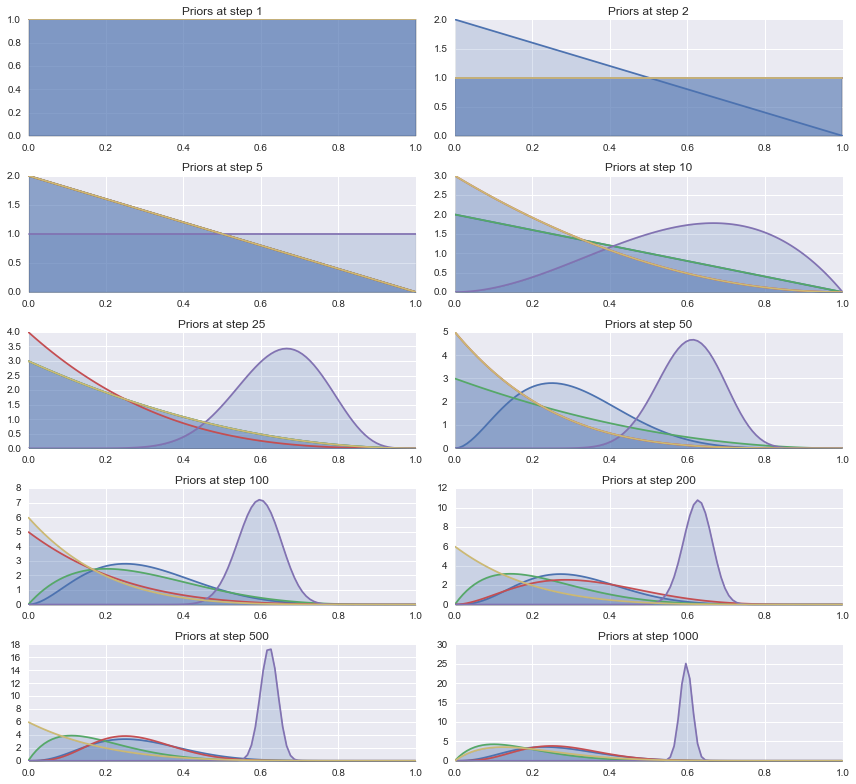

In [9]:
import sys
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
np.random.seed(42)
from collections import OrderedDict


Diff_Ad_Variations = OrderedDict([ ('Ad_1', .25), ('Ad_2', .22), ('Ad_3', .20), ('Ad_4', .60), ('Ad_5', .18)]) 

Trials = [0,0,0,0,0]

Wins = [0,0,0,0,0]



def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, 
    else return 0."""
    if np.random.rand() < Diff_Ad_Variations[i]:
        return 1
    else:
        return 0
    

# Define plotting functions
# Iterations to plot
plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]

# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(12.0, 11))
axs = axs.flat


def plot(priors, step, ax):
    """Plot the priors for the current step."""
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        ax.fill_between(plot_x, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(ymin=0)
    ax.set_title('Priors at step {}'.format(step))
    
    
    
n = 1000


### Bandit Algo
for step in range (1,n+1):
    bandit_priors= []
    for t, w in zip(Trials,Wins):
        bandit_priors.append (stats.beta(a=1+w, b= 1+t-w)) # start with uniform prior
    if step in plots:
        plot(bandit_priors, step, next(axs))
    #generate theta for each bandit
    thetas = [each.rvs() for each in bandit_priors]
    # pick the highest theta (this determines which ad will be shown)
    winner_index = np.argmax(thetas)
    winner_name = Diff_Ad_Variations.keys()[winner_index]
    # pull that theta. This determines the click.
    click = pull(winner_name)
    # Update all the trials and wins for the chosen bandit. Your samples should diverge here
    Wins[winner_index] += click
    Trials[winner_index]+=1
   
plt.tight_layout()
#plt.legend()
plt.show()

#### The code above does the following for each iteration:
    1. Starts with uniform beta distributions for all ads (equal probability of success and failures)
    2. Samples a theta (random variable) from each distribution
    3. Choses the largest theta among all the ads (initially this will be random)
    4. Pull that ad (similar to previous algorisms)
    5. Update the beta distribution of the pulled ad
    
This is a remarkably simple algorism that converges on the ad with the highest click through rate. It's worth noting, that while that convergence appears to occur very quickly based on the above plots, that is occurring due to a large difference in "real click through rate" of our ads. With similar click through rates, we would expect the distributions to be harder to discern and would see similar number of trials between ads that are similar in performance.  

### Takeaways

The bandit approaches, while less familiar to the general public, have several advantages over the more traditional frequentist methods. These advantages include:

* Optimization towards the most effective ad without active actions by the   owners of the A/B test. This means you make more money since you don’t waste time by showing people less effective ads. 
* Easily interpretable results. Visual representation of distributions avoids dealing with and explaining p values
* Avoids the fallacy of “peaking at results too early,” which happens all too common in the business setting. Since the distributions show the uncertainty of the estimate, there is less of a risk of jumping to conclusions too early (assuming the person is educated on how to interpret distributions. 

There are disadvantages to letting an algorism make decisions for you and these approaches are not always appropriate. Context and reasons for why an ad or offer is outperforming the other offers may be even more important than pushing the majority of your customers to the winner as soon as possible. However, bandit approaches to A/B testing are a great solution for specific tests and worth considering as part of your overall tech stack 
